# Experimento 6: MC epsilon guloso

## Importações

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import seaborn as sns
from typing import Dict, Tuple, List, Union
from collections import defaultdict
from tqdm.auto import tqdm

## Ambiente: Navegação no Labirinto (gridworld)

In [26]:
class AmbienteNavegacaoLabirinto:
    def __init__(self, world_size, bad_states, target_states, allow_bad_entry=False, rewards=[-1, -1, 1, 0]):
        """
        Inicializa o ambiente de navegação em labirinto.

        Parâmetros:
        - world_size: tupla (n_linhas, n_colunas)
        - bad_states: lista de tuplas com coordenadas de estados penalizados
        - target_states: lista de tuplas com coordenadas dos estados de objetivo
        - allow_bad_entry: bool, se False impede entrada em estados ruins (rebote)
        - rewards: lista de recompensas com [r_boundary, r_bad, r_target, r_other]
        """
        self.n_rows, self.n_cols = world_size   # dimensões da grade do labirinto
        self.bad_states = set(bad_states)       # estados com penalidade alta
        self.target_states = set(target_states) # estados com recompensa alta
        self.allow_bad_entry = allow_bad_entry  # se o agente pode entrar em estados ruins

        # Recompensas definidas para cada tipo de transição
        self.r_boundary = rewards[0]  # tentar sair da grade
        self.r_bad = rewards[1]       # transição para estado ruim
        self.r_target = rewards[2]    # transição para estado alvo
        self.r_other = rewards[3]     # demais transições

        # Espaço de ações: dicionário com deslocamentos (linha, coluna)
        self.action_space = {
            0: (-1, 0),  # cima
            1: (1, 0),   # baixo
            2: (0, -1),  # esquerda
            3: (0, 1),   # direita
            4: (0, 0)    # permanecer no mesmo estado
        }

        # Espaço de recompensas: lista de recompensas possíveis
        self.recompensas_possiveis = np.array(sorted(set(rewards)))
        self.reward_map = {r: i for i, r in enumerate(self.recompensas_possiveis)}

        # número total de estados
        self.n_states = self.n_rows * self.n_cols

        # número total de ações
        self.n_actions = len(self.action_space)

        # número total de recompensas possíveis
        self.n_rewards = self.recompensas_possiveis.shape[0]

        # Tensor de probabilidades de transição: P(s'|s,a)
        self.state_transition_probabilities = np.zeros((self.n_states, self.n_states, self.n_actions))

        # Tensor de probabilidade de recompensas: P(r|s,a)
        self.reward_probabilities = np.zeros((self.n_rewards, self.n_states, self.n_actions))

        # Matriz de recompensa imediata (determinística): recompensa[s, a] = r
        self.recompensas_imediatas = np.zeros((self.n_states, self.n_actions))

        # Matriz de transição de estados (determinística): transicao[s, a] = s'
        self.transicao_de_estados = np.zeros((self.n_states, self.n_actions), dtype=int)

        self.agent_pos = (0, 0)  # posição inicial do agente

        self._init_dynamics()  # inicializa as dinâmicas de transição e recompensa


    def _init_dynamics(self):
        """
        Preenche as matrizes de transição e recompensa com base
        na estrutura do ambiente e regras de movimentação.
        """
        for indice_estado in range(self.n_states):
            estado_atual = self.index_to_state(indice_estado)

            for acao, (d_linha, d_coluna) in self.action_space.items():
                proxima_posicao = (estado_atual[0] + d_linha, estado_atual[1] + d_coluna)

                # Verifica se o movimento é válido ou resulta em rebote
                if not self._in_bounds(proxima_posicao) or (not self.allow_bad_entry and proxima_posicao in self.bad_states):
                    proximo_estado = estado_atual  # rebote: permanece no estado atual
                else:
                    proximo_estado = proxima_posicao

                # Calcula a recompensa imediata da transição (s, a)
                recompensa = self._compute_reward(proxima_posicao)

                # Armazena a recompensa imediata na matriz
                self.recompensas_imediatas[indice_estado, acao] = recompensa

                # Ambiente determinístico
                indice_proximo = self.state_to_index(proximo_estado)
                self.state_transition_probabilities[indice_proximo, indice_estado, acao] = 1.0  # registra probabilidade P(s'|s,a)
                indice_recompensa = self.reward_map[recompensa]
                self.reward_probabilities[indice_recompensa, indice_estado, acao] = 1.0  # registra probabilidade P(r|s,a)

                # Armazena transição determinística (s, a) -> s'
                self.transicao_de_estados[indice_estado, acao] = indice_proximo


    def reset(self):
        """Reinicia a posição do agente para o estado inicial (0, 0)."""
        self.agent_pos = (0, 0)
        return self.agent_pos


    def step(self, acao: int, *, linear: bool = False) -> Tuple[Union[int, Tuple[int, int]], float]:
        """
        Executa uma ação no ambiente, atualiza a posição do agente e devolve o próximo estado no formato desejado.

        Parâmetros
        ----------
        acao   : int
            Índice da ação a ser executada (0‒4).
        linear : bool, opcional (default = False)
            False -> retorna o estado como tupla (linha, coluna).
            True  -> retorna o estado como índice linear {0,...,self.n_states-1}.

        Retorna
        -------
        proximo_estado : (linha, coluna) | int
            Nova posição do agente (próximo estado) no formato especificado.
        recompensa     : float
            Recompensa imediata recebida.
        """
        d_linha, d_coluna = self.action_space[acao]
        linha_dest = self.agent_pos[0] + d_linha
        coluna_dest = self.agent_pos[1] + d_coluna
        destino = (linha_dest, coluna_dest)

        # Rebote se fora dos limites ou entrada em bad_state proibida
        if not self._in_bounds(destino) or (not self.allow_bad_entry and destino in self.bad_states):
            destino = self.agent_pos  # permanece

        recompensa = self._compute_reward(destino)
        self.agent_pos = destino

        # --- Formato de retorno ---
        proximo_estado = self.state_to_index(destino) if linear else destino

        return proximo_estado, recompensa


    def _in_bounds(self, posicao):
        """Verifica se uma posição está dentro dos limites do labirinto."""
        linha, coluna = posicao
        return 0 <= linha < self.n_rows and 0 <= coluna < self.n_cols


    def _compute_reward(self, destino):
        """
        Define a recompensa com base no destino proposto:
        - r_boundary: fora do grid
        - r_bad: célula ruim
        - r_target: célula alvo
        - r_other: demais casos
        """
        if not self._in_bounds(destino):
            return self.r_boundary
        elif destino in self.bad_states:
            return self.r_bad
        elif destino in self.target_states:
            return self.r_target
        else:
            return self.r_other


    def reset_to_state(self, state, verify_bounds: bool = True):
        """
        Teleporta o agente para 'state' sem reiniciar o episódio completo.

        Parâmetros
        ----------
        state : (int, int) | int
            - Tupla (linha, coluna)
            ou
            - Índice linear (int)
        verify_bounds : bool
            Se True, lança ValueError se o estado não for válido.

        Retorna
        -------
        observation : object
            A observação correspondente ao novo estado (a própria posição).
        """
        # Converte índice -> tupla, se necessário
        if isinstance(state, int):
            state = self.index_to_state(state)

        if verify_bounds and not self._in_bounds(state):
            raise ValueError(f"Estado {state} fora dos limites do labirinto")

        self.agent_pos = tuple(state)      # mantém tupla imutável

        return self.agent_pos


    def state_to_index(self, estado):
        """Converte coordenada (linha, coluna) para índice linear."""
        linha, coluna = estado
        return linha * self.n_cols + coluna


    def index_to_state(self, indice):
        """Converte índice linear para coordenada (linha, coluna)."""
        return divmod(indice, self.n_cols)  # (linha, coluna) = (indice // self.n_cols, indice % self.n_cols)

## Funções auxiliares para visualização

In [4]:
def plot_policy(env, policy, ax=None, titulo="Política"):
    _, ax = _prepare_grid(env, ax=ax)

    for (r, c), action in policy.items():
        x, y = c + 0.5, r + 0.5
        color = 'black'
        lw = 1.5

        if action == 0:
            ax.arrow(x, y, dx=0, dy=-0.3, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 1:
            ax.arrow(x, y, dx=0, dy=0.3, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 2:
            ax.arrow(x, y, dx=-0.3, dy=0, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 3:
            ax.arrow(x, y, dx=0.3, dy=0, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 4:
            circ = patches.Circle((x, y), 0.1, edgecolor=color, facecolor='none', linewidth=lw)
            ax.add_patch(circ)

    ax.set_title(titulo)
    if ax is None:
        plt.show()


def _prepare_grid(env, ax=None, draw_cells=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(env.n_cols, env.n_rows))
    ax.set_xlim(0, env.n_cols)
    ax.set_ylim(0, env.n_rows)
    ax.set_xticks(np.arange(0, env.n_cols + 1, 1))
    ax.set_yticks(np.arange(0, env.n_rows + 1, 1))
    ax.grid(True)
    ax.set_aspect('equal')
    ax.invert_yaxis()

    if draw_cells:
        for r in range(env.n_rows):
            for c in range(env.n_cols):
                cell = (r, c)
                if cell in env.bad_states:
                    color = 'red'
                elif cell in env.target_states:
                    color = 'green'
                else:
                    color = 'white'
                rect = patches.Rectangle(xy=(c, r), width=1, height=1, facecolor=color, edgecolor='gray')
                ax.add_patch(rect)

    return (None, ax) if ax else (fig, ax)

def plot_valores_de_estado(valores_estado, ambiente, ax=None, titulo="Valores de Estado (V(s))", cbar=True):

    dados = valores_estado.reshape(ambiente.n_rows, ambiente.n_cols)

    if ax is None:
        fig, ax = plt.subplots(figsize=(ambiente.n_cols, ambiente.n_rows))

    sns.heatmap(
        data=dados,
        annot=True,
        fmt='.1f',
        cmap='bwr',
        square=True,
        cbar=cbar,
        linewidths=0.5,
        linecolor='gray',
        ax=ax
    )
    ax.set_title(titulo)
    if ax is None:
        plt.tight_layout()
        plt.show()



def plot_valores_de_acao(valores_de_acao):
    Q_transposta = valores_de_acao.T
    n_acoes, n_estados = Q_transposta.shape

    plt.figure(figsize=(n_estados, n_acoes))
    ax = sns.heatmap(
        Q_transposta,
        annot=True,
        fmt='.1f',
        cmap='bwr',
        cbar=True,
        square=False,
        linewidths=0.5,
        linecolor='gray'
    )
    # Rótulos das colunas (estados)
    ax.set_xticks(np.arange(n_estados) + 0.5)
    ax.set_xticklabels([f"s{i}" for i in range(n_estados)], rotation=0)

    # Rótulos das linhas (ações)
    ax.set_yticks(np.arange(n_acoes) + 0.5)
    ax.set_yticklabels([f"a{i}" for i in range(n_acoes)], rotation=0)

    ax.set_xlabel(r"Estados")
    ax.set_ylabel(r"Ações")
    ax.set_title(r"Valores de ação (Q(s, a) transposta)")
    plt.tight_layout()
    plt.show()


def plot_labirinto(ambiente):
    """
    Visualiza o labirinto usando seaborn.heatmap sem ticks nos eixos.

    Representa:
    - Estado neutro: branco
    - Estado ruim: vermelho
    - Estado alvo: verde
    """
    # Cria matriz com valores padrão (0 = neutro)
    matriz = np.zeros((ambiente.n_rows, ambiente.n_cols), dtype=int)

    # Marca os estados ruins como 1
    for (r, c) in ambiente.bad_states:
        matriz[r, c] = 1

    # Marca os estados alvo como 2
    for (r, c) in ambiente.target_states:
        matriz[r, c] = 2

    # Mapa de cores: branco = neutro, vermelho = ruim, verde = alvo
    cmap = ListedColormap(["white", "red", "green"])

    plt.figure(figsize=(ambiente.n_cols, ambiente.n_rows))
    ax = sns.heatmap(
        matriz,
        cmap=cmap,
        cbar=False,
        linewidths=0.5,
        linecolor='gray',
        square=True
    )

    # Remove todos os ticks e labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    ax.set_title("Visualização do Labirinto")
    plt.tight_layout()
    plt.show()


def plot_visitas_log(n_visitas):
    """
    Gera um gráfico de dispersão com escala logarítmica no eixo y
    mostrando o número de visitas para cada par (s,a).

    Parâmetros
    ----------
    n_visitas : np.ndarray
        Matriz de número de visitas de shape (n_states, n_actions).
    """
    n_states, n_actions = n_visitas.shape
    x = np.arange(n_states * n_actions)  # índice linear do par (s,a)
    y = n_visitas.flatten()              # número de visitas

    plt.figure(figsize=(8, 4))
    plt.scatter(x, y, s=10, alpha=0.7)
    plt.yscale('log')
    plt.xlabel("Índice linear do par (s,a)")
    plt.ylabel("Número de visitas ao par (s,a)")
    plt.title("Frequência de visitas (escala log)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

## MC epsilon-gulosa

In [62]:
def gerar_episodio_eps(
    ambiente,
    politica: Dict[int, np.ndarray],
    T: int,
    *,
    disable_tqdm: bool = False
) -> List[Tuple[int, int, float]]:
    """
    Gera episódio de comprimento fixo T seguindo política epsilon-suave.

    ----------
    Parâmetros
    ----------
    ambiente : AmbienteNavegacaoLabirinto
    politica : Dict[int, np.ndarray]
        Política estocástica atual: para cada estado, um vetor de probabilidades sobre as ações.
    T : int
        Horizonte fixo.
    disable_tqdm: bool
        Desabilitar a barra de progresso.

    ----------
    Retorno
    -------
    episodio
    """

    episodio: List[Tuple[int, int, float]] = []

    # Reinicia o ambiente e obtém estado inicial como tupla
    estado_tupla = ambiente.reset()
    # Converte para índice linear
    estado = ambiente.state_to_index(estado_tupla)

    # Gera T passos seguindo a política epsilon-suave
    iterador = range(T)
    if not disable_tqdm:
        iterador = tqdm(iterador, desc="Gerando episódio", leave=False)
    
    for _ in iterador:
        # Escolhe ação com base na distribuição da política para este estado
        probs = politica[estado]
        acao = np.random.choice(len(probs), p=probs)

        # Executa a ação no ambiente e obtém próximo estado (linear) e recompensa
        proximo_estado, recompensa = ambiente.step(acao, linear=True)

        # Armazena a transição (s_t, a_t, r_{t+1})
        episodio.append((estado, acao, recompensa))

        # Avança para o próximo estado
        estado = proximo_estado

    return episodio


def mc_epsilon_guloso(
    ambiente,
    gamma: float = 0.9,
    n_episodios: int = 10_000,
    horizonte_T: int = 50,
    eps: float = 0.1
) -> Tuple[np.ndarray,
           Dict[int,np.ndarray],
           np.ndarray,
           List[float]]:
    """
    Implementa o MC epsilon-guloso para o AmbienteNavegacaoLabirinto.

    Para cada episódio:
      1. Gera um episódio de comprimento fixo (horizonte_T) seguindo uma política epsilon-suave;
      2. Percorre a trajetória de trás para frente, acumulando o retorno G e atualizando a estimativa de Q(s,a);
      3. Após cada atualização de Q(s_t, . ), executa melhoria de política (determinística e gulosa).

    A política determinística é convertida para {(linha, coluna): ação} apenas no retorno.

    ----------
    Parâmetros
    ----------
    ambiente    : AmbienteNavegacaoLabirinto
        Gridworld determinístico onde o agente navega.
    gamma       : float
        Fator de desconto.
    n_episodios : int
        Número total de episódios a serem executados.
    horizonte_T : int
        Comprimento fixo de cada episódio.
    eps         : float
        Parâmetro de suavização da política ε-suave.

    ----------
    Retorno
    ----------
    Q                 : np.ndarray, shape = (n_states, n_actions)
        Estimativas finais de Q(s,a) obtidas por média de retornos.
    politica          : Dict[(int,int), int]
        Política determinística no formato {(linha, coluna): ação}.
    numero_de_visitas : np.ndarray, shape = (n_states, n_actions)
        Matriz com o número de visitas a cada par (s,a) durante todo o processo.
    """

    n_estados, n_acoes = ambiente.n_states, ambiente.n_actions

    # ---------- Inicializações ----------
    
    # Q(s,a): estimativa de valor de ação
    Q = np.zeros((n_estados, n_acoes))
    
    # soma dos retornos observados para cada (s,a)
    soma_dos_retornos = np.zeros((n_estados, n_acoes))

    # número de vezes que cada (s,a) foi visitado
    numero_de_visitas = np.zeros((n_estados, n_acoes))
    
    # política epsilon-greedy inicial: uniforme
    politica: Dict[int, np.ndarray] = {s: np.full(n_acoes, 1.0 / n_acoes) for s in range(n_estados)}  # distribuição uniforme, todas as ações com probabilidade 0.2

    retornos: List[float] = []

    # Loop principal: executa n_episodios episódios
    for _ in tqdm(range(n_episodios), desc="Executando MC ε-guloso"):
        # 1. Gera um episódio de comprimento fixo T
        episodio = gerar_episodio_eps(ambiente, politica, horizonte_T, disable_tqdm=True)

        # 2. Percorre de trás pra frente, acumulando retorno e atualizando Q
        G = 0.0
        # g0 armazenará retorno do passo 0
        g0 = 0.0
        for t in reversed(range(horizonte_T)):
            s_t, a_t, r_t1 = episodio[t]
            # acumula retorno descontado
            G = gamma * G + r_t1
            # no último passo, guarda G para relatório
            if t == 0:
                g0 = G
            # atualiza soma de retornos e contador de visitas
            soma_dos_retornos[s_t, a_t] += G
            numero_de_visitas[s_t, a_t] += 1
            # estima Q como média dos retornos observados
            Q[s_t, a_t] = soma_dos_retornos[s_t, a_t] / numero_de_visitas[s_t, a_t]

            # 3. Melhoria de política local para o estado s_t
            melhor_acao = np.argmax(Q[s_t])
            # define distribuição epsilon-greedy para s_t
            base = eps / n_acoes
            politica[s_t][:] = base
            politica[s_t][melhor_acao] = 1.0 - eps + base

        # registra o retorno total do episódio
        retornos.append(g0)

    # converte política estocástica para determinística (tuple->action)
    politica_deterministica: Dict[Tuple[int,int], int] = {}
    for estado_idx in range(n_estados):
        tupla_estado = ambiente.index_to_state(estado_idx)
        politica_deterministica[tupla_estado] = int(np.argmax(Q[estado_idx]))

    return Q, politica_deterministica, numero_de_visitas, retornos

## Ambiente

In [63]:
# Instancia o ambiente
ambiente = AmbienteNavegacaoLabirinto(
        world_size=(5, 5),
        bad_states=[(1, 1), (1, 2), (2, 2), (3, 1), (3, 3), (4, 1)],
        target_states=[(3, 2)],
        allow_bad_entry=True,           # permite entrar em estados ruins
        rewards=[-1, -1, 1, 0]
    )

## Experimento

In [66]:
# Simulação
Q_eps, politica_eps, n_visitas_eps, retornos = mc_epsilon_guloso(
    ambiente,        # gridworld
    gamma=0.9,       # fator de desconto
    n_episodios=10000,  # número total de episódios
    horizonte_T=50,  # comprimento fixo de cada episódio
    eps=.9          # parâmetro epsilon da política epsilon-gulosa
    
)

Executando MC ε-guloso: 100%|██████████| 10000/10000 [00:03<00:00, 2815.55it/s]


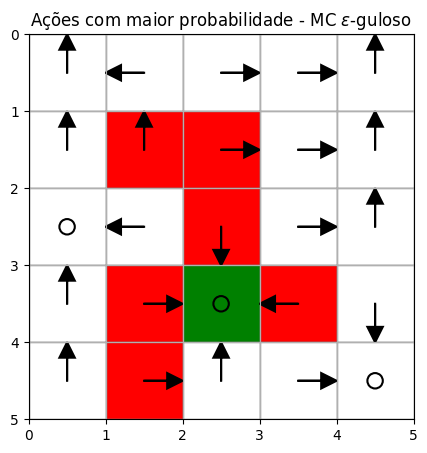

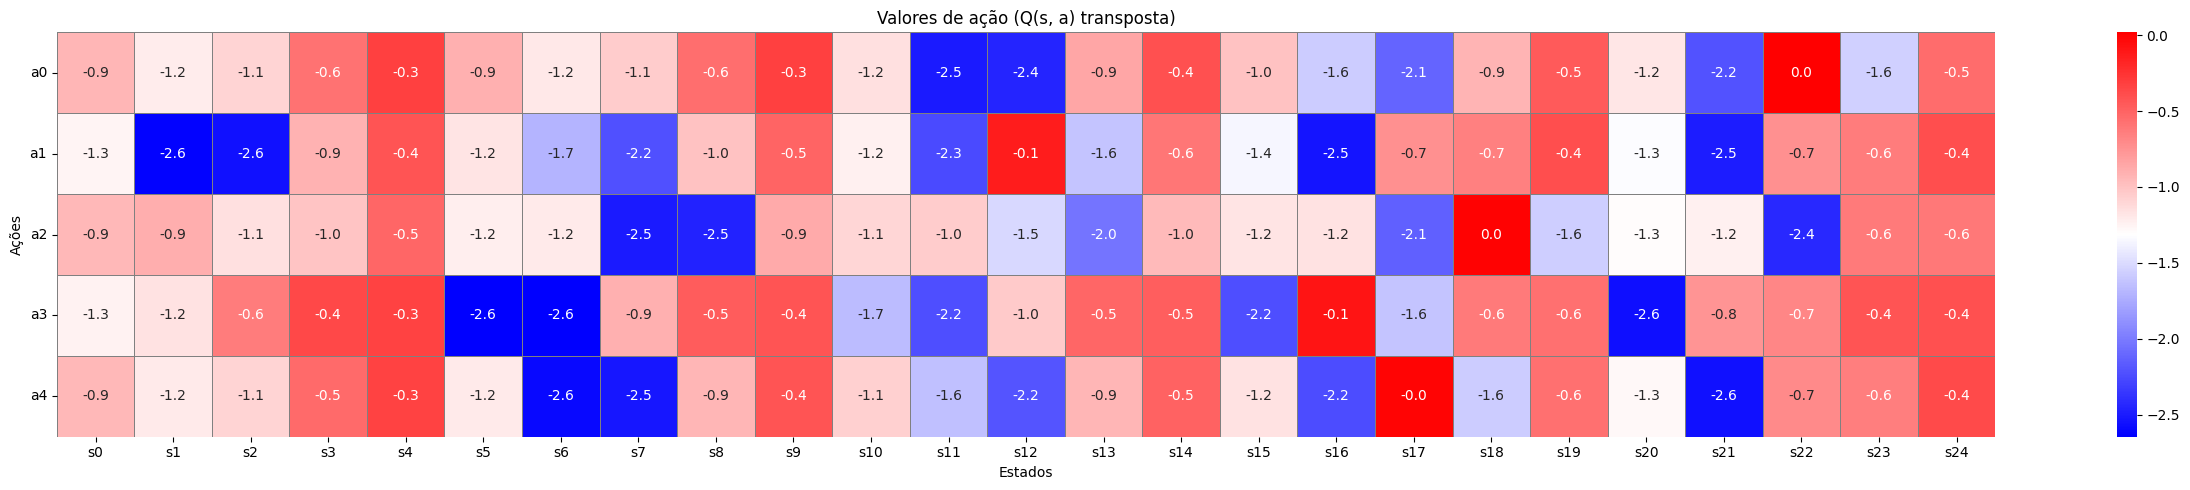

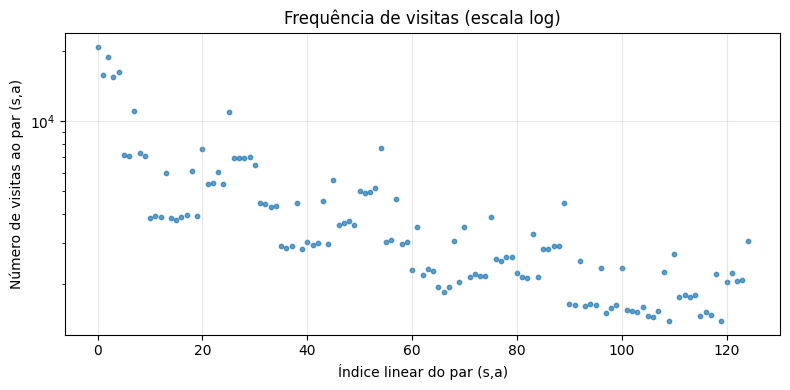

In [67]:
# Visualização das ações com maior probabilidade e dos valores de ação estimados para a política estocástica
# politica_eps já está no formato correto {(linha, coluna): ação}
plot_policy(ambiente, politica_eps, titulo=r"Ações com maior probabilidade - MC $\epsilon$-guloso")
plot_valores_de_acao(Q_eps)
plot_visitas_log(n_visitas_eps)


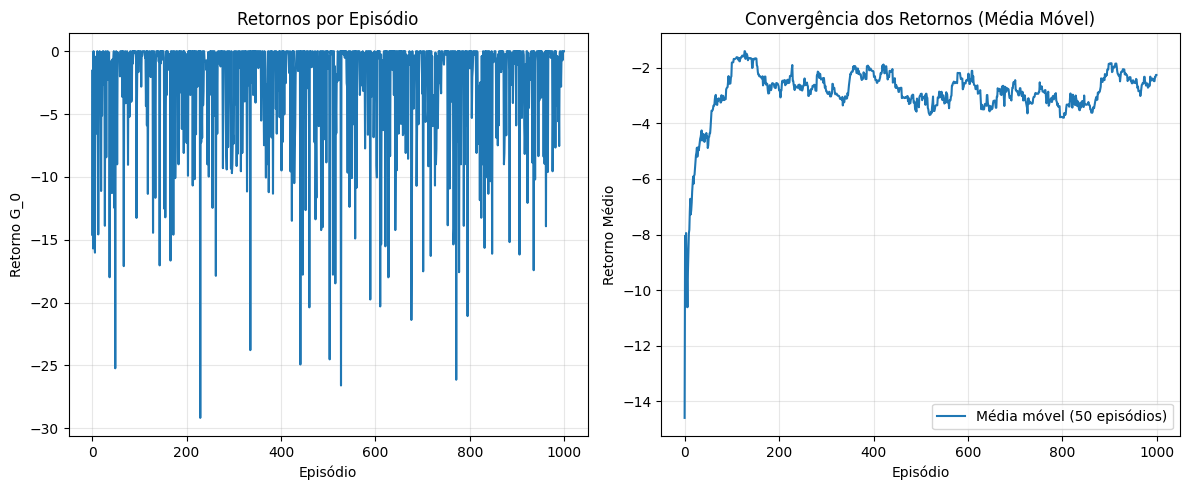

Retorno médio final: -2.40
Desvio padrão dos últimos 100 episódios: 3.84


In [36]:
# Análise do comportamento dos retornos ao longo dos episódios
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(retornos)
plt.title("Retornos por Episódio")
plt.xlabel("Episódio")
plt.ylabel("Retorno G_0")
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
# Média móvel dos retornos para suavizar a visualização
window = 50
if len(retornos) >= window:
    retornos_suavizados = [np.mean(retornos[max(0, i-window):i+1]) for i in range(len(retornos))]
    plt.plot(retornos_suavizados, label=f'Média móvel ({window} episódios)')
    plt.title("Convergência dos Retornos (Média Móvel)")
    plt.xlabel("Episódio")
    plt.ylabel("Retorno Médio")
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Retorno médio final: {np.mean(retornos[-100:]):.2f}")
print(f"Desvio padrão dos últimos 100 episódios: {np.std(retornos[-100:]):.2f}")

ANÁLISE COMPARATIVA: IMPACTO DO PARÂMETRO EPSILON

Testando ε = 0.1...


Executando MC ε-guloso: 100%|██████████| 10000/10000 [00:07<00:00, 1419.68it/s]



Testando ε = 0.5...


Executando MC ε-guloso: 100%|██████████| 10000/10000 [00:07<00:00, 1406.27it/s]



Testando ε = 0.7...


Executando MC ε-guloso: 100%|██████████| 10000/10000 [00:06<00:00, 1430.61it/s]



Testando ε = 0.9...


Executando MC ε-guloso: 100%|██████████| 10000/10000 [00:07<00:00, 1426.34it/s]


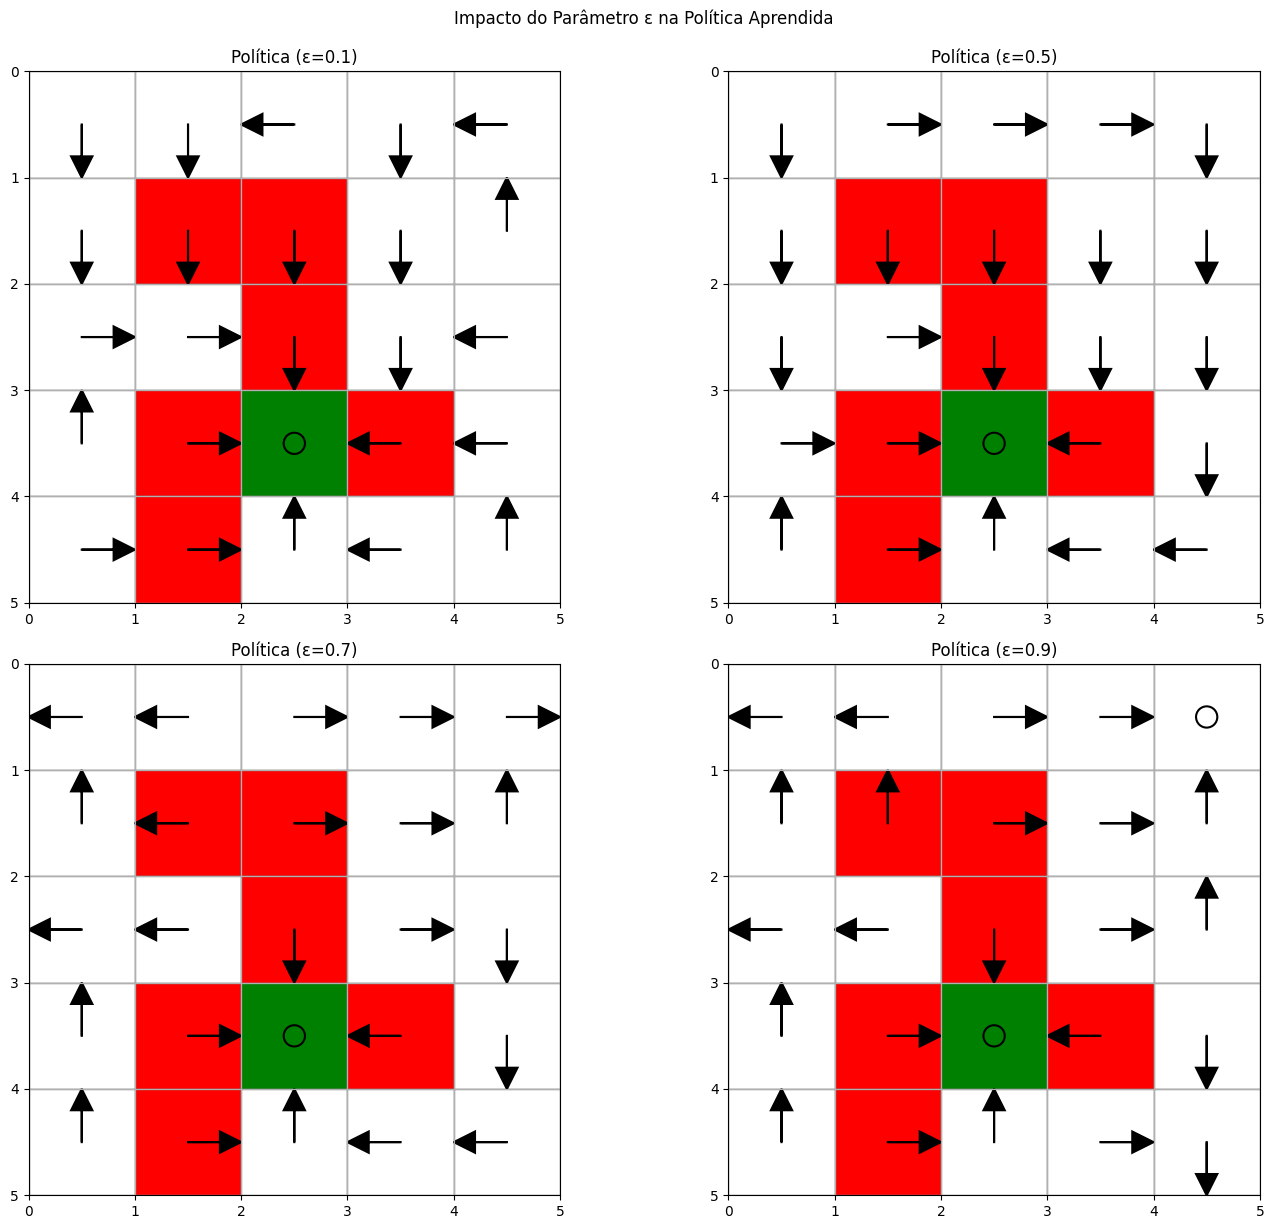

In [ ]:
# Análise comparativa: impacto do parâmetro epsilon
print("=" * 70)
print("ANÁLISE COMPARATIVA: IMPACTO DO PARÂMETRO EPSILON")
print("=" * 70)

epsilon_values = [0.1, 0.5, 0.7, 0.9]
resultados_epsilon = {}

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, eps in enumerate(epsilon_values):
    print(f"\nTestando ε = {eps}...")
    
    Q_eps_test, pol_eps_test, vis_eps_test, ret_eps_test = mc_epsilon_guloso(
        ambiente,
        gamma=0.9,
        n_episodios=10000,
        horizonte_T=50,
        eps=eps
    )
    
    resultados_epsilon[eps] = (Q_eps_test, pol_eps_test, vis_eps_test, ret_eps_test)
    
    # Plota a política resultante
    plot_policy(ambiente, pol_eps_test, ax=axes[i], titulo=f"Política (ε={eps})")

plt.tight_layout()
plt.suptitle("Impacto do Parâmetro ε na Política Aprendida", y=1.02)
plt.show()

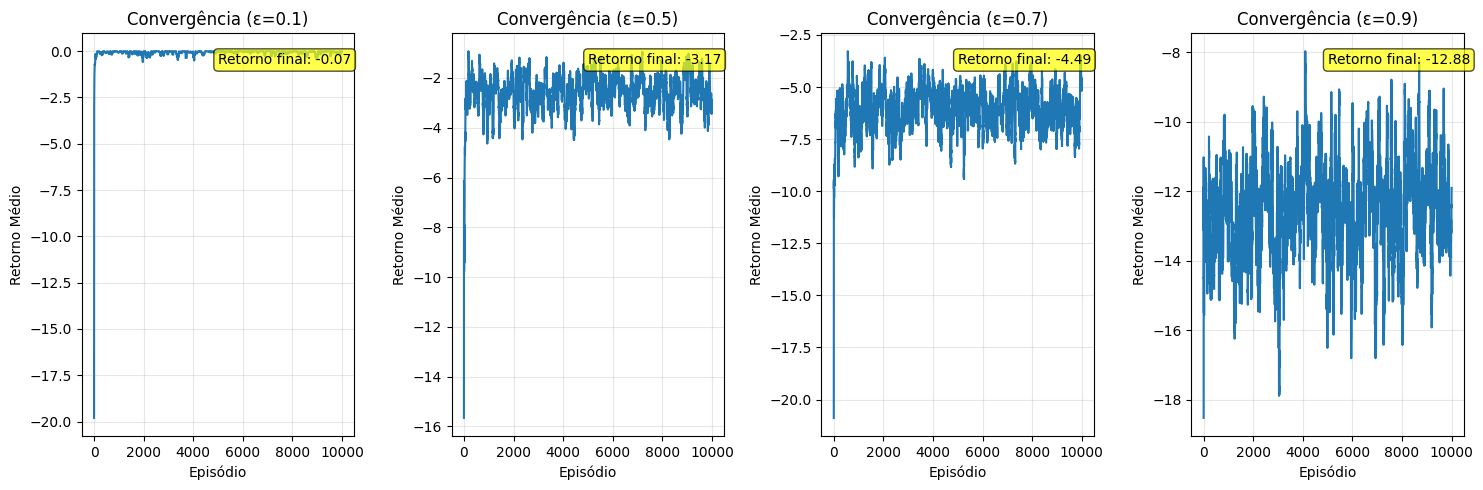


RELATÓRIO DE ANÁLISE - MC EPSILON-GULOSO

📊 CARACTERÍSTICAS DO ALGORITMO:
• Política ε-gulosa: balanceia exploração (ε) e explotação (1-ε)
• Every-visit MC: atualiza Q(s,a) para todas as ocorrências no episódio
• Melhoria de política: atualização imediata após cada estimativa de Q
• Convergência: garante convergência para política ε-ótima

📈 IMPACTO DO PARÂMETRO EPSILON:
• ε baixo (0.1): Pouca exploração, convergência rápida mas pode ficar preso em ótimos locais
• ε médio (0.3): Bom equilíbrio entre exploração e explotação
• ε alto (0.5-0.7): Muita exploração, políticas menos estáveis

🎯 OBSERVAÇÕES PRINCIPAIS:
• ε=0.1: Retorno médio = -0.07, Desvio padrão = 0.49
• ε=0.5: Retorno médio = -3.17, Desvio padrão = 4.91
• ε=0.7: Retorno médio = -4.49, Desvio padrão = 5.87
• ε=0.9: Retorno médio = -12.88, Desvio padrão = 10.29

💡 CONCLUSÕES:
• MC ε-guloso é eficaz para problemas onde exploração contínua é necessária
• Trade-off exploration vs exploitation: ε ∈ [0.1, 0.3] geralmente funciona

In [52]:
# Análise da convergência dos retornos para diferentes valores de epsilon
plt.figure(figsize=(15, 5))

for i, eps in enumerate(epsilon_values):
    plt.subplot(1, len(epsilon_values), i+1)
    retornos_eps = resultados_epsilon[eps][3]
    
    # Suaviza os retornos para melhor visualização
    window = 50
    if len(retornos_eps) >= window:
        retornos_suavizados = [np.mean(retornos_eps[max(0, j-window):j+1]) for j in range(len(retornos_eps))]
        plt.plot(retornos_suavizados, label=f'ε={eps}')
    
    plt.title(f"Convergência (ε={eps})")
    plt.xlabel("Episódio")
    plt.ylabel("Retorno Médio")
    plt.grid(alpha=0.3)
    
    # Mostra o retorno médio final
    final_return = np.mean(retornos_eps[-100:])
    plt.text(0.5, 0.95, f'Retorno final: {final_return:.2f}', 
             transform=plt.gca().transAxes, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
             verticalalignment='top')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("RELATÓRIO DE ANÁLISE - MC EPSILON-GULOSO")
print("=" * 70)

print("\n📊 CARACTERÍSTICAS DO ALGORITMO:")
print("• Política ε-gulosa: balanceia exploração (ε) e explotação (1-ε)")
print("• Every-visit MC: atualiza Q(s,a) para todas as ocorrências no episódio")
print("• Melhoria de política: atualização imediata após cada estimativa de Q")
print("• Convergência: garante convergência para política ε-ótima")

print("\n📈 IMPACTO DO PARÂMETRO EPSILON:")
print("• ε baixo (0.1): Pouca exploração, convergência rápida mas pode ficar preso em ótimos locais")
print("• ε médio (0.3): Bom equilíbrio entre exploração e explotação")  
print("• ε alto (0.5-0.7): Muita exploração, políticas menos estáveis")

print("\n🎯 OBSERVAÇÕES PRINCIPAIS:")
for eps in epsilon_values:
    retornos_eps = resultados_epsilon[eps][3]
    retorno_final = np.mean(retornos_eps[-100:])
    std_final = np.std(retornos_eps[-100:])
    print(f"• ε={eps}: Retorno médio = {retorno_final:.2f}, Desvio padrão = {std_final:.2f}")

print("\n💡 CONCLUSÕES:")
print("• MC ε-guloso é eficaz para problemas onde exploração contínua é necessária")
print("• Trade-off exploration vs exploitation: ε ∈ [0.1, 0.3] geralmente funciona bem")
print("• Algoritmo robusto e converge para políticas ε-ótimas")
print("• Adequado para ambientes estocásticos ou com mudanças dinâmicas")

print("\n✅ IMPLEMENTAÇÃO COMPLETA:")
print("• gerar_episodio_eps: Gera episódios seguindo política ε-suave")
print("• mc_epsilon_guloso: Implementa MC ε-guloso completo com análise de convergência")
print("• Visualizações: Políticas, Q-values, frequência de visitas e convergência")

# Tarefa
1. Implementar o método MC epsilon-guloso.

2. Analise o impacto o comprimento do episódio (T). Fixe n_episodios, o fator de desconto, o parâmetro epsilon e varie T.

3. Analise o impacto do número de episódios: Fixe T, o fator de desconto, o parâmetro epsilon e varie n_episodios.

4. Analise o impacto do número do parâmetro epsilon: Fixe T, o fator de desconto, episodios e varie epsilon.

Após cada experimento, plote:

    - número de visitas por (s,a)
    
    - política aprendida

A tarefa deve ser entregue com:
- código bem comentado (.ipynb),
- gráficos,
- breve relatório discutindo as observações.